# SARIMA Forecasting Simple
Following the tutorial ["Kaggle SARIMA"](https://www.kaggle.com/code/nholloway/seasonality-and-sarimax)

Tutorial ["Deconstructing ARIMA"](https://www.kaggle.com/code/nholloway/deconstructing-arima)


In [55]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import boxcox, kurtosis, skew
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

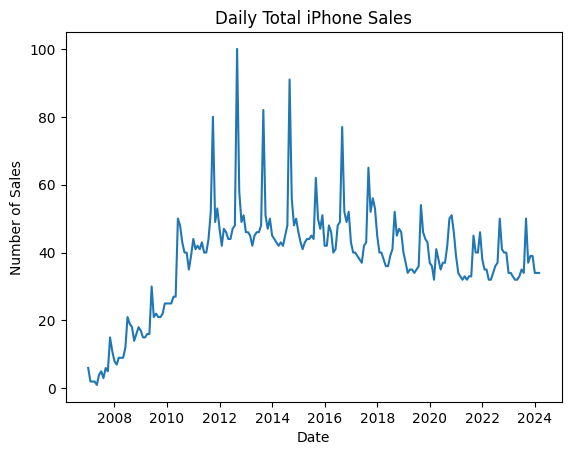

In [56]:
# Load the dataset
data = pd.read_csv('iphone_sales.csv')

# rename columns
data.columns = ['date', 'sales']

# Convert the date column to a datestamp type
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Plot the time series
plt.plot(data['sales'])
plt.title('Daily Total iPhone Sales')
plt.xlabel('Date')
plt.ylabel('Number of Sales')
plt.show()

### Drop data from before 2012 because it does not accurately represent the current trend.

In [57]:
# drop data from before date 2012-01-01
data = data.loc['2012-01-01':]
data.head()

,sales
date,
2012-01-01,47
2012-02-01,42
2012-03-01,47
2012-04-01,46
2012-05-01,44


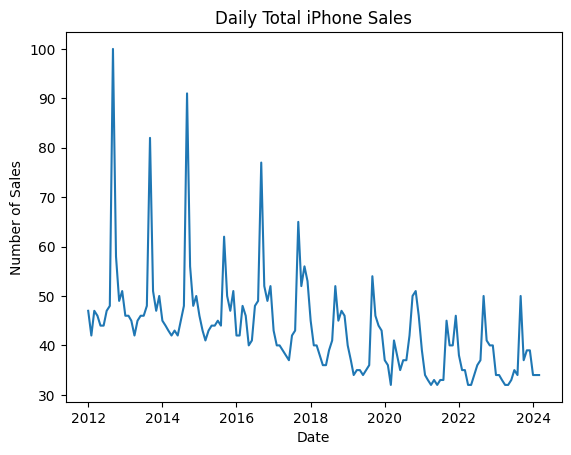

In [58]:
# Plot the time series
plt.plot(data['sales'])
plt.title('Daily Total iPhone Sales')
plt.xlabel('Date')
plt.ylabel('Number of Sales')
plt.show()

## Check for Stationarity

In [59]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(data['sales'])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -0.882576
p-value: 0.793656


p-value is above 0.05 so data does not meet the stationarity requirement.

## Remove Trend

Test a simple differencing and see if the downward trend is removed

In [60]:
# Calculate the first difference of the time series to remove the trend from the data
data['data_sales'] = data['sales'].diff()

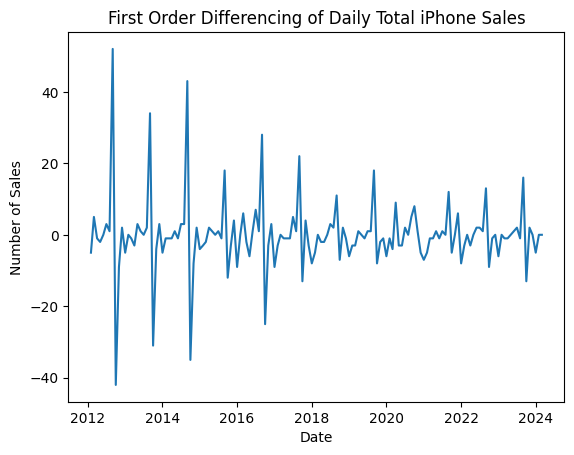

In [61]:
# plot the time series of data1_sales
plt.plot(data['data_sales'])
plt.title('First Order Differencing of Daily Total iPhone Sales')
plt.xlabel('Date')
plt.ylabel('Number of Sales')
plt.show()


In [62]:
adf_test = adfuller(data['data_sales'].dropna())
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -7.112502
p-value: 0.000000


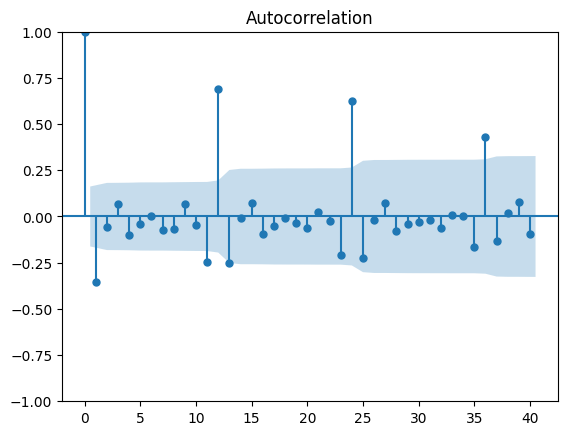

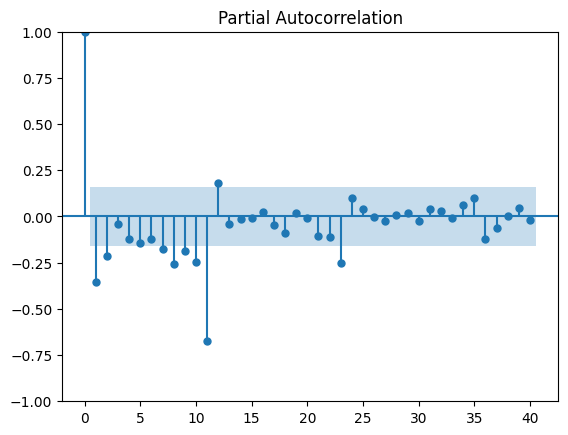

In [63]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data['data_sales'].dropna(), lags=40)
plot_pacf(data['data_sales'].dropna(), lags=40)
plt.show()

Use the Autocorrelation and Partial Autocorrelation plots to find p and q for the ARIMA (p, d, q) values.

In [64]:
model = SARIMAX(data['sales'], freq='MS', order=(1, 1, 1), seasonal_order=(1, 0, 0, 12))
model_fit = model.fit(disp=False) 

# adjust the steps for the number of days to forecast
forecast = model_fit.get_forecast(steps=30)

test_forecast_series = pd.Series(forecast.predicted_mean)

c:\Users\dagar\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


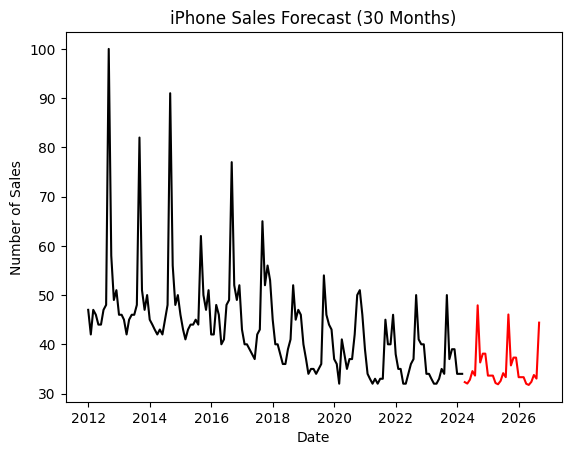

In [65]:
# plot the data['sales'] and the forecast
plt.plot(data['sales'], label='observed', color='black')
plt.plot(test_forecast_series, label='forecast', color='red')
plt.title('iPhone Sales Forecast (30 Months)')
plt.xlabel('Date')
plt.ylabel('Number of Sales')
plt.show()

In [66]:
# view the forecast
print("Min Training Date:", data.index.min())
print("Min Forecast Date:", test_forecast_series.index.min())
print("Max Forecast Date:", test_forecast_series.index.max())
print('Number of Forecast Observations:', len(test_forecast_series))

print(test_forecast_series.tail(10))

Min Training Date: 2012-01-01 00:00:00
Min Forecast Date: 2024-04-01 00:00:00
Max Forecast Date: 2026-09-01 00:00:00
Number of Forecast Observations: 30
2025-12-01    37.300871
2026-01-01    33.321030
2026-02-01    33.320999
2026-03-01    33.320987
2026-04-01    31.980552
2026-05-01    31.749228
2026-06-01    32.374449
2026-07-01    33.763526
2026-08-01    33.041975
2026-09-01    44.399642
Freq: MS, Name: predicted_mean, dtype: float64


## Test the Model Performance

In [67]:
# create a train and test set
train = data.loc[:'2022-01-01', 'sales']
test = data.loc['2022-01-01':, 'sales']

c:\Users\dagar\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


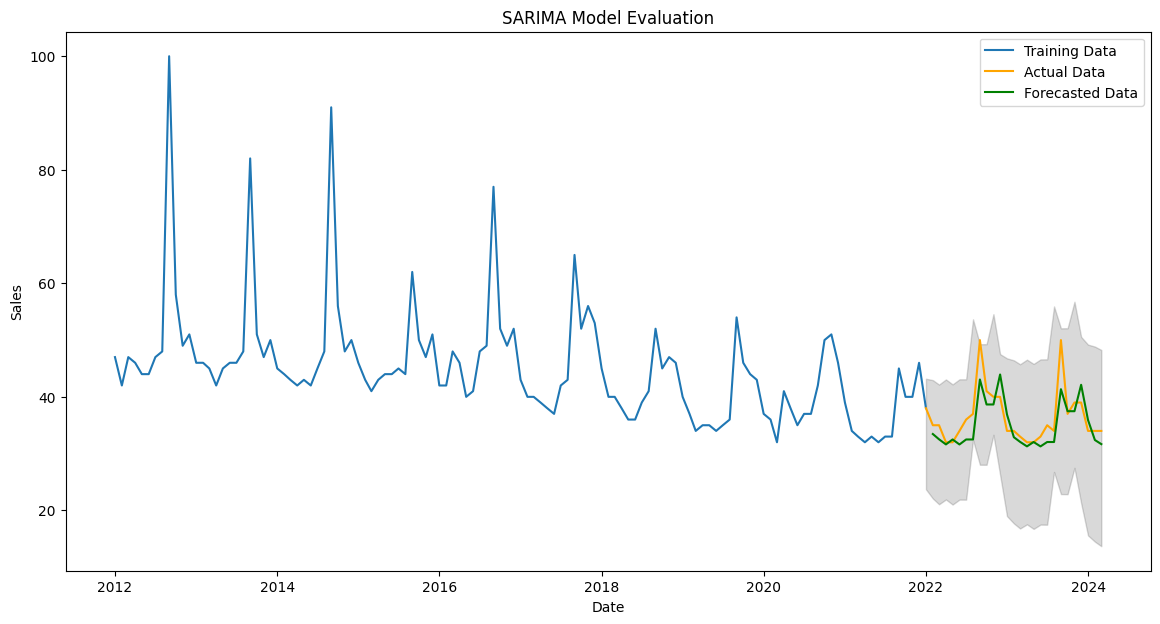

RMSE: 3.06144626331811


In [68]:
# Fit the SARIMA model on the training dataset
model_train = SARIMAX(train, freq='MS', order=(1, 1, 1), seasonal_order=(1, 0, 0, 12))
model_train_fit = model_train.fit()

# Forecast on the test dataset
test_forecast = model_train_fit.get_forecast(steps=len(test))
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test.index)

# drop the first value of the test_forecast_series
test_forecast_series = test_forecast_series[1:]

# Calculate the mean squared error
mse = mean_squared_error(test[1:], test_forecast_series)
rmse = mse**0.5

# Create a plot to compare the forecast with the actual test data
plt.figure(figsize=(14,7))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.fill_between(test.index, 
                 test_forecast.conf_int().iloc[:, 0], 
                 test_forecast.conf_int().iloc[:, 1], 
                 color='k', alpha=.15)
plt.title('SARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

print('RMSE:', rmse)